In [1]:
from pathlib import Path
from tqdm import tqdm

In [31]:
DATA_ROOT   = Path("/media/dtsarev/SatSSD/data")
TRAIN_CSV   = DATA_ROOT / "train_split.csv"
VAL_CSV     = DATA_ROOT / "valid_split.csv"

EMB_IMG_DIR = Path("./cached_embeddings_img")
EMB_AUD_DIR = Path("./audio_hubert_embeds")
EMB_TXT_DIR = Path("./text_embeddings_roberta")

IMG_DIM     = 1280   # EfficientNet‑B0 last pooling layer
AUD_DIM     = 768    # HuBERT large hidden size
TXT_DIM     = 768    # RoBERTa‑base hidden size

USE_AUDIO_STATS = True   # if True -> mean+std+min+max (4×768)

PROJ_DIM        = 256    # output dim of each modality projection

TRAIN_BATCH_SIZE = 128   # smaller batch helps convergence with new net
NUM_EPOCHS       = 80
LR               = 2e-4
WEIGHT_DECAY     = 1e-4
EARLY_STOP_PATIENCE = 10
SEED = 42

EMOTIONS = ["Admiration","Amusement","Determination","Empathic Pain","Excitement","Joy"]
NUM_CLASSES = len(EMOTIONS)

device = "cuda" if __import__("torch").cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [3]:
import random, numpy as np, pandas as pd, torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [4]:
def load_npy(path:Path):
    if not path.exists():
        return None
    arr = np.load(path)
    return None if arr.size==0 else arr

def aggregate_audio(arr:np.ndarray):
    if arr is None:
        return None
    if arr.ndim==1:
        return arr.astype(np.float32)
    mean, std = arr.mean(0), arr.std(0)
    mn, mx    = arr.min(0),  arr.max(0)
    return np.concatenate([mean,std,mn,mx]).astype(np.float32) if USE_AUDIO_STATS else mean.astype(np.float32)

In [5]:
class MultiModalDataset(Dataset):
    def __init__(self,csv_path:Path,tag:str):
        df = pd.read_csv(csv_path,dtype={"Filename":str})
        df['Filename']=df['Filename'].str.zfill(5)
        self.samples=[]
        self.targets=[]
        for vid,*tgt in df[['Filename',*EMOTIONS]].values:
            img = load_npy(EMB_IMG_DIR/f"{vid}.npy")
            aud_path = next((p for p in [EMB_AUD_DIR/f"{tag}_{vid}.npy", EMB_AUD_DIR/f"{vid}.npy"] if p.exists()), None)
            aud = load_npy(aud_path) if aud_path else None
            txt = load_npy(EMB_TXT_DIR/f"{vid}.npy")
            aud = aggregate_audio(aud)
            if img is None or aud is None or txt is None:
                continue
            self.samples.append(np.concatenate([img,txt,aud]).astype(np.float32))
            self.targets.append(np.array(tgt,dtype=np.float32))
        self.samples=np.stack(self.samples)
        self.targets=np.stack(self.targets)
        print(f"{tag}: {len(self.samples)} triples")
    def __len__(self): return len(self.samples)
    def __getitem__(self,i):
        return torch.from_numpy(self.samples[i]), torch.from_numpy(self.targets[i])

In [6]:
def pearson_corr(p,t):
    vx,vy = p-p.mean(0), t-t.mean(0)
    return (vx*vy).sum(0)/(torch.sqrt((vx**2).sum(0)*(vy**2).sum(0))+1e-8)

class PearsonLoss(nn.Module):
    def forward(self,p,t):
        return 1-pearson_corr(p,t).mean()

In [7]:
class FusionRegressor(nn.Module):
    def __init__(self, in_dim_img:int, in_dim_txt:int, in_dim_aud:int):
        super().__init__()
        self.in_dim_img=in_dim_img
        self.in_dim_txt=in_dim_txt
        self.in_dim_aud=in_dim_aud
        self.proj_img = nn.Sequential(nn.LayerNorm(in_dim_img), nn.Linear(in_dim_img, PROJ_DIM), nn.GELU())
        self.proj_txt = nn.Sequential(nn.LayerNorm(in_dim_txt), nn.Linear(in_dim_txt, PROJ_DIM), nn.GELU())
        self.proj_aud = nn.Sequential(nn.LayerNorm(in_dim_aud), nn.Linear(in_dim_aud, PROJ_DIM), nn.GELU())
        self.head = nn.Sequential(
            nn.Linear(PROJ_DIM*3, 512), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, NUM_CLASSES), nn.Sigmoid()
        )
    def forward(self,x):
        img = x[:,:self.in_dim_img]
        txt = x[:,self.in_dim_img:self.in_dim_img+self.in_dim_txt]
        aud = x[:,self.in_dim_img+self.in_dim_txt:]
        h = torch.cat([self.proj_img(img), self.proj_txt(txt), self.proj_aud(aud)], dim=-1)
        return self.head(h)

In [35]:
train_ds = MultiModalDataset(TRAIN_CSV,'train')
val_ds   = MultiModalDataset(VAL_CSV,'val')
train_dl = DataLoader(train_ds,batch_size=TRAIN_BATCH_SIZE,shuffle=True,drop_last=True)
val_dl   = DataLoader(val_ds,  batch_size=TRAIN_BATCH_SIZE,shuffle=False)

feat_sample,_ = next(iter(train_dl))
IMG_DIM = EMB_IMG_DIR.glob('*.npy').__next__().stat().st_size  # dummy, real slice already known
TXT_DIM = 768
AUD_DIM = 768*4 if USE_AUDIO_STATS else 768

model = FusionRegressor(feat_sample.shape[1]-TXT_DIM-AUD_DIM, TXT_DIM, AUD_DIM).to(device)
loss_fn = PearsonLoss()
opt     = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched   = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

train: 7953 triples
val: 4565 triples


In [36]:
hist={k:[] for k in ['tl','vl','tr','vr']}
best_r=-1e9
wait=0

for epoch in range(1,NUM_EPOCHS+1):
    for phase,dl in [('train',train_dl),('val',val_dl)]:
        is_train=(phase=='train')
        if is_train:
            model.train()
        else:
            model.eval()
        loss_tot=r_tot=n=0
        for xb,yb in dl:
            xb,yb = xb.to(device), yb.to(device)
            if is_train: opt.zero_grad()
            with torch.set_grad_enabled(is_train):
                pred = model(xb)
                loss = loss_fn(pred,yb)
                if is_train: loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(),1.0)
                    opt.step()
            r = pearson_corr(pred,yb).mean().item()
            bs=xb.size(0)
            loss_tot+=loss.item()*bs
            r_tot+=r*bs
            n+=bs
        hist_key = ('t' if phase=='train' else 'v')
        hist[f'{hist_key}l'].append(loss_tot/n)
        hist[f'{hist_key}r'].append(r_tot/n)
    sched.step(hist['vl'][-1])
    print(f"Ep{epoch:02d}: Ltr {hist['tl'][-1]:.3f} Lval {hist['vl'][-1]:.3f} | Rtr {hist['tr'][-1]:.3f} Rval {hist['vr'][-1]:.3f}")
    if hist['vr'][-1]>best_r+1e-4:
        best_r=hist['vr'][-1]
        best_state={k:v.cpu() for k,v in model.state_dict().items()}
        wait=0
    else:
        wait+=1
        if wait>=EARLY_STOP_PATIENCE:
            print('Early stop')
            break

model.load_state_dict(best_state)

Ep01: Ltr 0.985 Lval 0.939 | Rtr 0.015 Rval 0.061
Ep02: Ltr 0.955 Lval 0.918 | Rtr 0.045 Rval 0.082
Ep03: Ltr 0.862 Lval 0.819 | Rtr 0.138 Rval 0.181
Ep04: Ltr 0.762 Lval 0.765 | Rtr 0.238 Rval 0.235
Ep05: Ltr 0.685 Lval 0.732 | Rtr 0.315 Rval 0.268
Ep06: Ltr 0.630 Lval 0.703 | Rtr 0.370 Rval 0.297
Ep07: Ltr 0.593 Lval 0.685 | Rtr 0.407 Rval 0.315
Ep08: Ltr 0.564 Lval 0.677 | Rtr 0.436 Rval 0.323
Ep09: Ltr 0.531 Lval 0.672 | Rtr 0.469 Rval 0.328
Ep10: Ltr 0.513 Lval 0.663 | Rtr 0.487 Rval 0.337
Ep11: Ltr 0.499 Lval 0.658 | Rtr 0.501 Rval 0.342
Ep12: Ltr 0.476 Lval 0.667 | Rtr 0.524 Rval 0.333
Ep13: Ltr 0.468 Lval 0.662 | Rtr 0.532 Rval 0.338
Ep14: Ltr 0.454 Lval 0.667 | Rtr 0.546 Rval 0.333
Ep15: Ltr 0.438 Lval 0.665 | Rtr 0.562 Rval 0.335
Ep16: Ltr 0.421 Lval 0.671 | Rtr 0.579 Rval 0.329
Ep17: Ltr 0.406 Lval 0.667 | Rtr 0.594 Rval 0.333
Ep18: Ltr 0.376 Lval 0.665 | Rtr 0.624 Rval 0.335
Ep19: Ltr 0.361 Lval 0.666 | Rtr 0.639 Rval 0.334
Ep20: Ltr 0.353 Lval 0.670 | Rtr 0.647 Rval 0.330


<All keys matched successfully>

In [37]:
model.eval()
preds,labels=[],[]

with torch.no_grad():
    for xb,yb in val_dl:
        preds.append(model(xb.to(device)).cpu())
        labels.append(yb)

P=torch.cat(preds)
T=torch.cat(labels)
print("Per‑emotion Pearson R (validation):")
for i,e in enumerate(EMOTIONS):
    r=pearson_corr(P[:,i],T[:,i]).item()
    print(f"{e:<15} r={r:+.3f}")
mean_r = pearson_corr(P,T).mean().item()
print(f"Mean r: {mean_r:+.3f}")

Per‑emotion Pearson R (validation):
Admiration      r=+0.421
Amusement       r=+0.349
Determination   r=+0.325
Empathic Pain   r=+0.452
Excitement      r=+0.293
Joy             r=+0.297
Mean r: +0.356


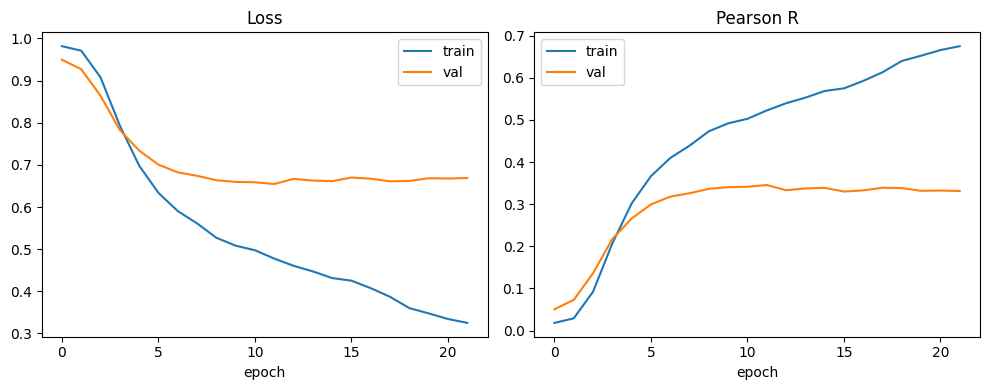

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['tl'],label='train')
plt.plot(hist['vl'],label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['tr'],label='train')
plt.plot(hist['vr'],label='val')
plt.title('Pearson R')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Per‑emotion correlations reported for each single modality
R_TXT = np.array([0.4732,0.3510,0.3656,0.3886,0.3360,0.3089])   # Adm,Amu,Det,Emp,Exc,Joy
R_AUD = np.array([0.3672,0.2098,0.2472,0.4252,0.2922,0.2632])
R_IMG = np.array([0.0019,0.0863,0.0502,0.0941,0.0842,0.1171])
R_stack = np.stack([R_IMG,R_AUD,R_TXT],axis=0)           # shape (3,6)
W = R_stack / R_stack.sum(0,keepdims=True)               # normalised weights (mod,emo)
print("Per‑emotion modality weights (IMG, AUD, TXT):", np.round(W,3))

# --- load validation predictions of each unimodal regressor ---
try:
    preds_txt = np.load('txt_val_preds.npy')   # shape (N,6)
    preds_aud = np.load('aud_val_preds.npy')
    preds_img = np.load('img_val_preds.npy')
    assert preds_txt.shape==preds_aud.shape==preds_img.shape==P.shape
    P_ens = (W[2]*preds_txt + W[1]*preds_aud + W[0]*preds_img)
    ens_r = pearson_corr(torch.tensor(P_ens), T).item()
    print(f"Weighted ensemble mean R: {ens_r:+.3f}")
except FileNotFoundError:
    print("Provide txt_val_preds.npy, aud_val_preds.npy, img_val_preds.npy to evaluate weighted ensemble.")

Per‑emotion modality weights (IMG, AUD, TXT): [[0.002 0.133 0.076 0.104 0.118 0.17 ]
 [0.436 0.324 0.373 0.468 0.41  0.382]
 [0.562 0.542 0.551 0.428 0.472 0.448]]
Provide txt_val_preds.npy, aud_val_preds.npy, img_val_preds.npy to evaluate weighted ensemble.


In [16]:
torch.save({'state_dict':model.state_dict(),'proj_dim':PROJ_DIM,'use_audio_stats':USE_AUDIO_STATS}, 'mm_regressor_v2.pth')